# Retention rate of contributors using talk page features

[Task](https://phabricator.wikimedia.org/T233889)

## Definitions:

**Junior Contributors:** Registered users who have made <100 cumulative contributions to a Wikipedia project.

**30-day Retention:** Contributors who come back to make an edit in any one of Wikipedia's 16 talk page namespaces within the 30 days that follows the "cool down" period after their first edit during the given month. We have defined the "cool down" period as the 24 hours that follow a contributor's first edit.

**Cohort**: Junior contributors completes at least on edit to a talk page in a given month between October 2016 through October 2019. 

**Second-Month Retention:**  Of the junior contributors who complete at least one edit on a talk page in a given month, how many make any edits in the second 30 days after that first edit.

Note: The below analysis looks at a single retention rate over different cohorts. I reviewed several different retention rate periods for comparison. 

TODOS:
- Other possible routes of investiageion: Decay in a cohort’s retention across all successive retention periods?

In [8]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

# 30-Day Contributor Retention Rate

In [37]:
query<-
"WITH first_edits AS (
-- table with users first edit in the cohort month
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN min(event_user_revision_count) is NULL THEN 'undefined'
            WHEN min(event_user_revision_count) < 100 THEN 'under 100'
            WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count) < 500) THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH')
)
 
SELECT
    month,
    initial_edit_count,
    (count(30_days.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is between two and 30 days
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (2*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (30*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS 30_days
ON 
(first_edits.user_name = 30_days.user_name and
first_edits.first_edit_time = 30_days.first_edit_time
)
GROUP BY first_edits.month, first_edits.initial_edit_count" 

In [38]:
talk_contributor_retention_30day <- wmf::query_hive(query)

In [39]:
write.csv(talk_contributor_retention_30day, file = "Data/talk_contributor_retention_30day.csv")

In [40]:
talk_contributor_retention_30day  <- read.csv(file = "Data/talk_contributor_retention_30day.csv", header = TRUE)

In [41]:
talk_contributor_retention_30day$month <- as.Date(talk_contributor_retention_30day$month, format = "%Y-%m-%d")



In [42]:
talk_contributor_retention_30day<- talk_contributor_retention_30day %>%
  filter(month != "2019-10-01") %>% #remove last month due to data censoring at end of month
select(-1)

In [43]:
head(talk_contributor_retention_30day)

month,initial_edit_count,retention_rate
<date>,<fct>,<dbl>
2016-10-01,100-499,0.4597792
2016-10-01,500+,0.7372407
2016-10-01,under 100,0.2203331
2016-11-01,100-499,0.4622894
2016-11-01,500+,0.7404287
2016-11-01,under 100,0.2090817


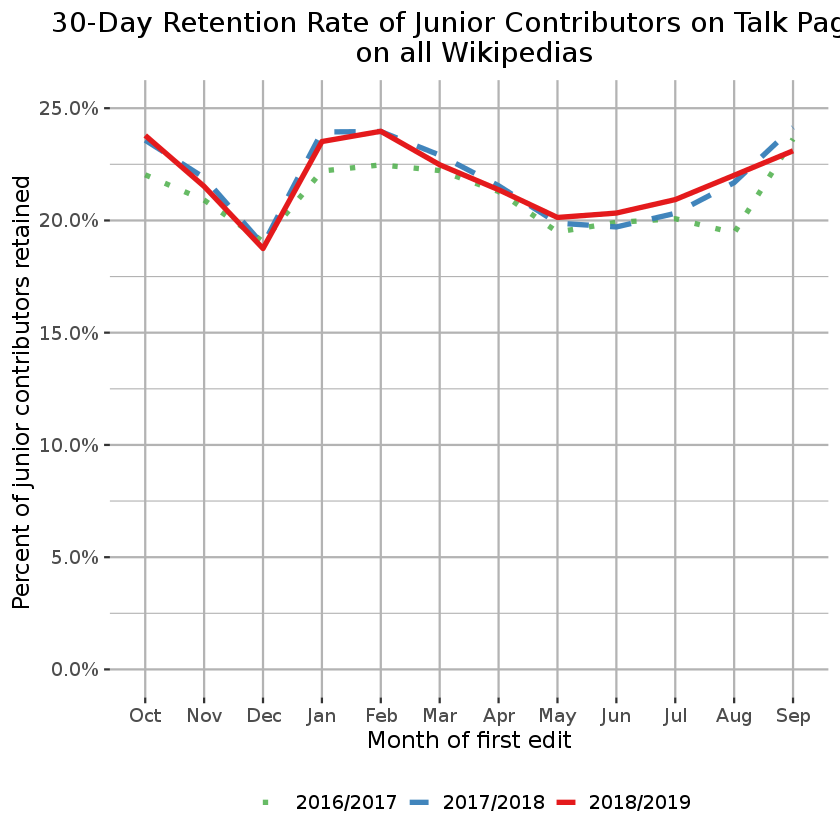

In [56]:
# Plot YoY Changes for Junior Contributors


talk_contributor_retention_30day_yoy_plot <- talk_contributor_retention_30day %>%
 filter(initial_edit_count == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_retention_30day_yoy_plot $MonthN = factor(talk_contributor_retention_30day_yoy_plot$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

talk_contributor_retention_30day_yoy_plot $year = factor(talk_contributor_retention_30day_yoy_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_retention_30day_yoy_plot , aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent, limits = c(0, 0.25)) +
  scale_x_discrete(breaks = talk_contributor_retention_30day_yoy_plot$MonthN, labels = talk_contributor_retention_30day_yoy_plot$CalMonth)+
  labs(title = "30-Day Retention Rate of Junior Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_retention_30day_yoy_plot.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [73]:
# Calculate junior year over year retention

talk_contributor_retention_30_day_yoy <- talk_contributor_retention_30day %>%
   filter(initial_edit_count == 'under 100') %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_retention_yoy, 50)

month,user_edit_count_bucket,retention_rate,yoy_percent
<date>,<fct>,<dbl>,<dbl>
2019-09-01,under 100,0.2296203,-4.2904155
2019-08-01,under 100,0.2182372,1.6052437
2019-07-01,under 100,0.2065844,2.9063811
2019-06-01,under 100,0.2013698,3.1623944
2019-05-01,under 100,0.1995802,1.6977868
2019-04-01,under 100,0.2118018,-0.9219142
2019-03-01,under 100,0.2232190,-1.8805716
2019-02-01,under 100,0.2379133,0.1443747
2019-01-01,under 100,0.2333942,-1.7544535


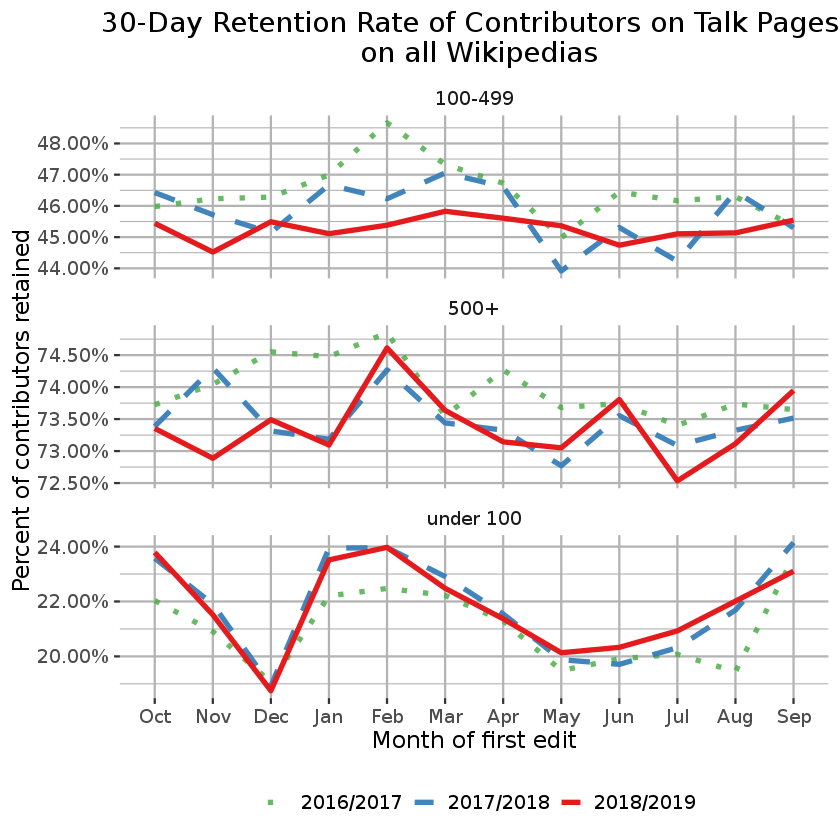

In [57]:
talk_contributor_retention_30_day_yoy_byexperience_plot <- talk_contributor_retention_30day %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_retention_30_day_yoy_byexperience_plot$MonthN = factor(talk_contributor_retention_30_day_yoy_byexperience_plot$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

talk_contributor_retention_30_day_yoy_byexperience_plot$year = factor(talk_contributor_retention_30_day_yoy_byexperience_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_retention_30_day_yoy_byexperience_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~initial_edit_count, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_retention_30_day_yoy_byexperience_plot$MonthN, labels = talk_contributor_retention_30_day_yoy_byexperience_plot$CalMonth)+
  labs(title = "30-Day Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_retention_30_day_yoy_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

# Second month retention rate

In [5]:
query<-
"WITH first_edits AS (
-- table with users first edit in the cohort month
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN min(event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count_bucket,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH'),
     CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END
)
 
SELECT
    month,
    user_edit_count_bucket,
    (count(2nd_month.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is during the second month
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (30*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (60*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS 2nd_month
ON 
(first_edits.user_name = 2nd_month.user_name and
first_edits.first_edit_time = 2nd_month.first_edit_time
)
GROUP BY first_edits.month, first_edits.user_edit_count_bucket" 

In [6]:
talk_contributor_2nd_month_retention <- wmf::query_hive(query)

In [7]:
write.csv(talk_contributor_2nd_month_retention, file = "Data/talk_contributor_2nd_month_retention.csv")

In [19]:
talk_contributor_2nd_month_retention <- read.csv(file = "Data/talk_contributor_2nd_month_retention.csv", header = TRUE)

In [22]:
head(talk_contributor_2nd_month_retention)

X,month,user_edit_count_bucket,retention_rate
<int>,<date>,<fct>,<dbl>
1,2016-10-01,100-499,0.3723294
2,2016-10-01,500+,0.7055318
3,2016-10-01,under 100,0.1191291
4,2016-11-01,100-499,0.3658251
5,2016-11-01,500+,0.7023512
6,2016-11-01,under 100,0.0925352


In [21]:
talk_contributor_2nd_month_retention$month <- as.Date(talk_contributor_2nd_month_retention$month, format = "%Y-%m-%d")


In [23]:
talk_contributor_2nd_month_retention <- talk_contributor_2nd_month_retention %>%
  filter(month < "2019-09-01") %>% # Remove last two months due to censoring 
  select (-1)

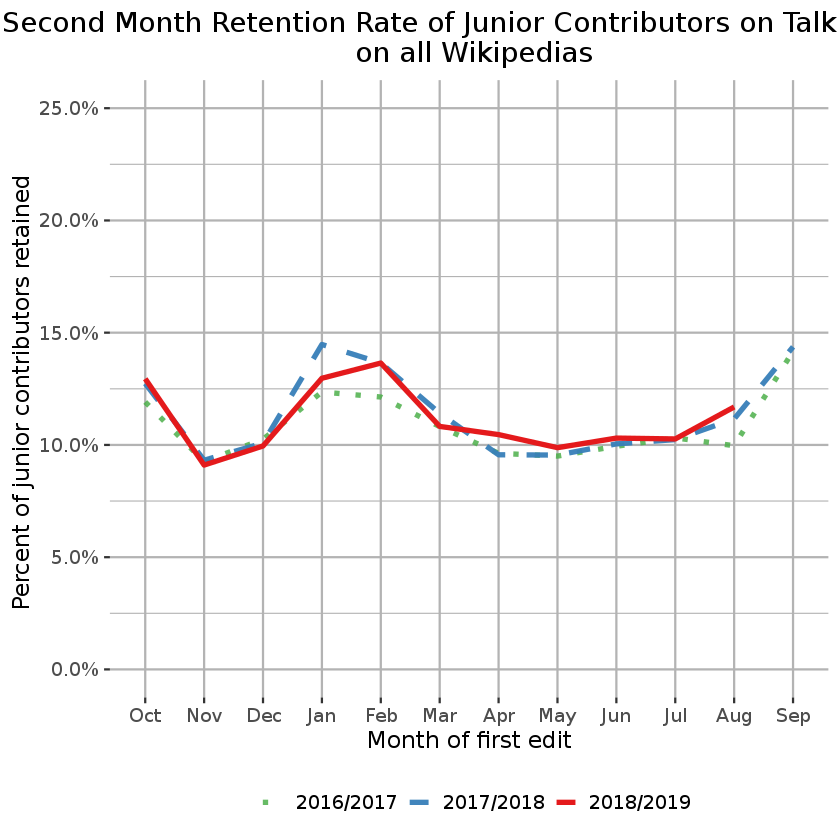

In [25]:
# Plot YoY Changes for Junior Contributors


junior_long_term_retention_yoy <- talk_contributor_2nd_month_retention %>%
 filter(user_edit_count_bucket == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


junior_long_term_retention_yoy$MonthN = factor(junior_long_term_retention_yoy$MonthN, levels=c("10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09" ))
junior_long_term_retention_yoy$year = factor(junior_long_term_retention_yoy$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(junior_long_term_retention_yoy, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent, limits = c(0, 0.25)) +
  scale_x_discrete(breaks = junior_long_term_retention_yoy$MonthN, labels = junior_long_term_retention_yoy$CalMonth)+
  labs(title = "Second Month Retention Rate of Junior Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="junior_contributor_retention_2nd_month.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [27]:
head(talk_contributor_2nd_month_retention)

month,user_edit_count_bucket,retention_rate
<date>,<fct>,<dbl>
2016-10-01,100-499,0.3723294
2016-10-01,500+,0.7055318
2016-10-01,under 100,0.1191291
2016-11-01,100-499,0.3658251
2016-11-01,500+,0.7023512
2016-11-01,under 100,0.0925352


In [39]:
# Calculate junior year over year for second month retention

talk_contributor_2nd_month_retention_yoy_rates <- talk_contributor_2nd_month_retention %>%
    filter(user_edit_count_bucket == 'under 100')  %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_2nd_month_retention_yoy_rates, 10)

month,user_edit_count_bucket,retention_rate,yoy_percent
<date>,<fct>,<dbl>,<dbl>
2019-08-01,under 100,0.11692446,4.78869529
2019-07-01,under 100,0.10267283,0.29283723
2019-06-01,under 100,0.10305000,2.56990824
2019-05-01,under 100,0.09878433,3.45910301
2019-04-01,under 100,0.10460335,9.41378281
2019-03-01,under 100,0.10825481,-5.12617589
2019-02-01,under 100,0.13647413,-0.02891714
2019-01-01,under 100,0.12970879,-10.38971611
2018-12-01,under 100,0.09953755,-1.25496331


## Second month retention by experience

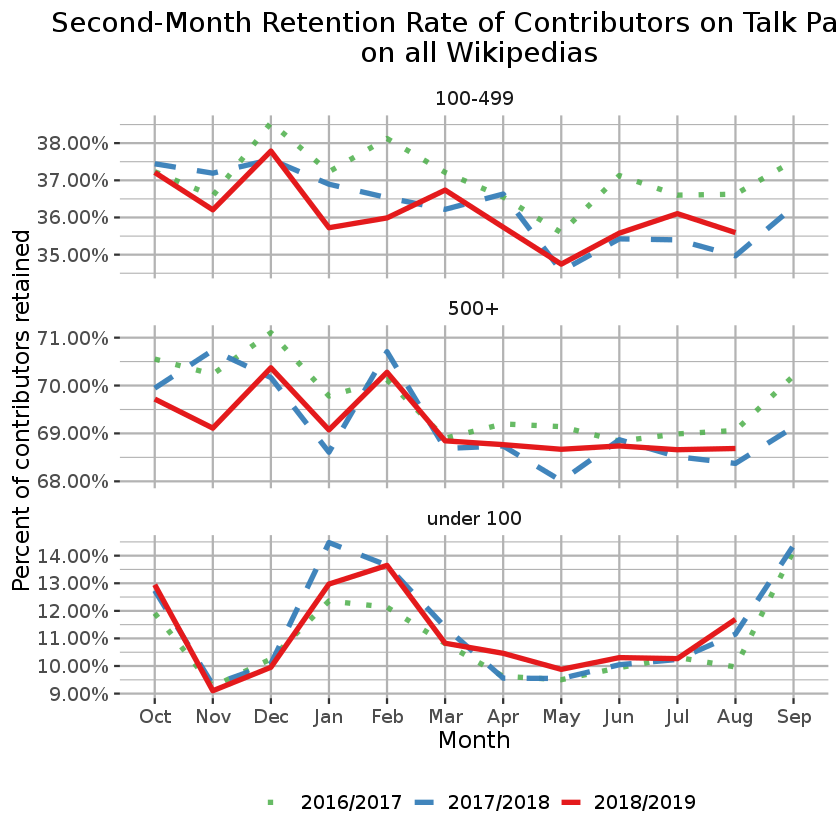

In [26]:
contributor_2nd_month_retention_yoy_byexperience <- talk_contributor_2nd_month_retention %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


contributor_2nd_month_retention_yoy_byexperience$MonthN = factor(contributor_2nd_month_retention_yoy_byexperience$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

contributor_2nd_month_retention_yoy_byexperience$year = factor(contributor_2nd_month_retention_yoy_byexperience$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(contributor_2nd_month_retention_yoy_byexperience, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~user_edit_count_bucket, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = contributor_2nd_month_retention_yoy_byexperience$MonthN, labels = contributor_2nd_month_retention_yoy_byexperience$CalMonth)+
  labs(title = "Second-Month Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="2nd_month_contributor_yoy_retention_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

# Second-Week Retention Rates

In [40]:
query<-
"WITH first_edits AS (
-- table with users first edit in the cohort month
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count_bucket,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH'),
     CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END
)
 
SELECT
    month,
    user_edit_count_bucket,
    (count(2nd_week.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is during the second month
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (7*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (14*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS 2nd_week
ON 
(first_edits.user_name = 2nd_week.user_name and
first_edits.first_edit_time = 2nd_week.first_edit_time
)
GROUP BY first_edits.month, first_edits.user_edit_count_bucket" 

In [41]:
talk_contributor_2nd_week_retention <- wmf::query_hive(query)

In [42]:
write.csv(talk_contributor_2nd_week_retention, file = "Data/talk_contributor_2nd_week_retention.csv")

In [22]:
talk_contributor_2nd_week_retention <- read.csv(file = "data/talk_contributor_2nd_month_retention.csv", header = TRUE)

In [23]:
talk_contributor_2nd_week_retention$month <- as.Date(talk_contributor_2nd_week_retention$month, format = "%Y-%m-%d")


In [24]:
talk_contributor_2nd_week_retention <- talk_contributor_2nd_week_retention %>%
  filter(month < "2019-09-01") # Remove last two months due to censoring 
  

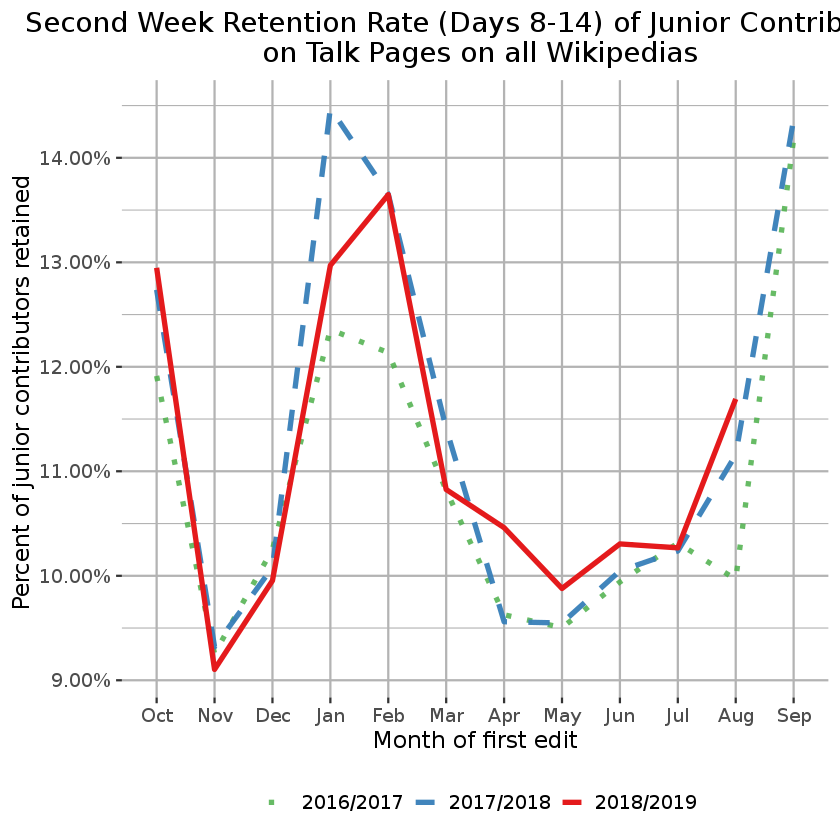

In [31]:
# Plot YoY Changes for Junior Contributors


talk_contributor_2nd_week_retention_yoy_plot <- talk_contributor_2nd_week_retention %>%
 filter(user_edit_count_bucket == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_2nd_week_retention_yoy_plot$MonthN = factor(talk_contributor_2nd_week_retention_yoy_plot$MonthN, levels=c("10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09" ))
talk_contributor_2nd_week_retention_yoy_plot$year = factor(talk_contributor_2nd_week_retention_yoy_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_2nd_week_retention_yoy_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_2nd_week_retention_yoy_plot$MonthN, labels = talk_contributor_2nd_week_retention_yoy_plot$CalMonth)+
  labs(title = "Second Week Retention Rate (Days 8-14) of Junior Contributors \n on Talk Pages on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_2nd_week_retention_yoy.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [30]:
# Calculate junior year over year retention

talk_contributor_2nd_week_retention_yoy <- talk_contributor_2nd_week_retention %>%
   filter(user_edit_count_bucket == 'under 100') %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_2nd_week_retention_yoy, 10)

X,month,user_edit_count_bucket,retention_rate,yoy_percent
<int>,<date>,<fct>,<dbl>,<dbl>
105,2019-08-01,under 100,0.11692446,4.78869529
102,2019-07-01,under 100,0.10267283,0.29283723
99,2019-06-01,under 100,0.10305000,2.56990824
96,2019-05-01,under 100,0.09878433,3.45910301
93,2019-04-01,under 100,0.10460335,9.41378281
90,2019-03-01,under 100,0.10825481,-5.12617589
87,2019-02-01,under 100,0.13647413,-0.02891714
84,2019-01-01,under 100,0.12970879,-10.38971611
81,2018-12-01,under 100,0.09953755,-1.25496331


In [42]:
avg <-  talk_contributor_2nd_week_retention_yoy %>%
    summarise(avg = mean(retention_rate))

avg

avg
<dbl>
0.1111159


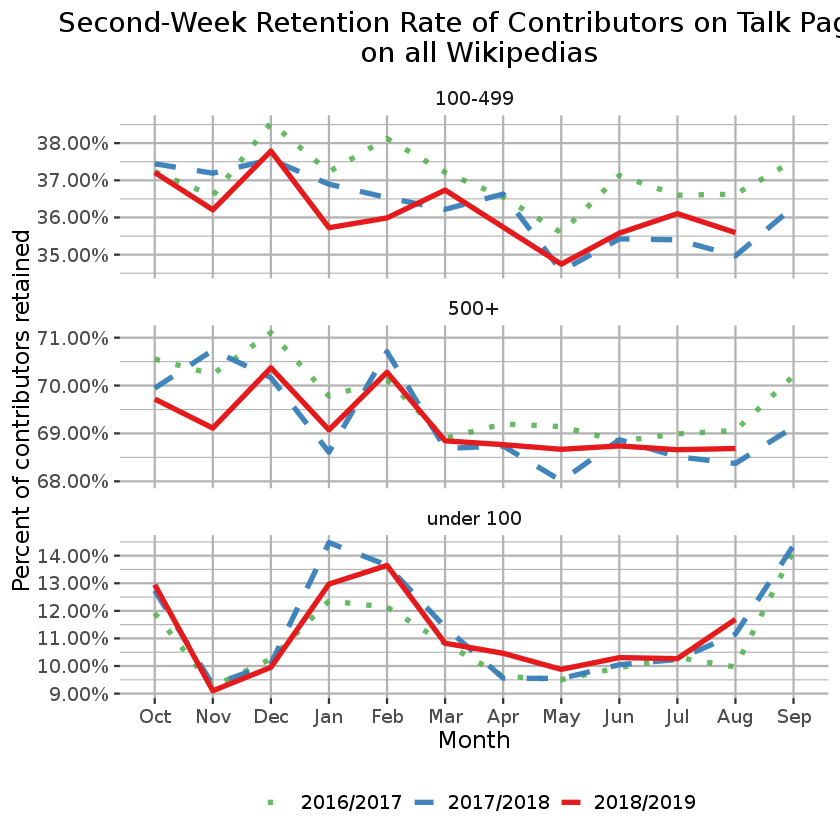

In [28]:
## Second week retention rate by user experience

contributor_retention_yoy_byexperience_2nd_week <- talk_contributor_2nd_week_retention %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


contributor_retention_yoy_byexperience_2nd_week$MonthN = factor(contributor_retention_yoy_byexperience_2nd_week$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

contributor_retention_yoy_byexperience_2nd_week$year = factor(contributor_retention_yoy_byexperience_2nd_week$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(contributor_retention_yoy_byexperience_2nd_week, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~user_edit_count_bucket, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = contributor_retention_yoy_byexperience_2nd_week$MonthN, labels = contributor_retention_yoy_byexperience_2nd_week$CalMonth)+
  labs(title = "Second-Week Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="2nd_week_contributor_yoy_retention_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

# First week retention rates (2-7 days)

In [51]:
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query<-
"WITH first_edits AS (
--  user who made edit in cohort month
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN min(event_user_revision_count) is NULL THEN 'undefined'
            WHEN min(event_user_revision_count) < 100 THEN 'under 100'
            WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count) < 500) THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH')
)
 
SELECT
    month,
    initial_edit_count,
    (count(first_week.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is during the first week
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (2*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (7*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS first_week
ON 
(first_edits.user_name = first_week.user_name and
first_edits.first_edit_time = first_week.first_edit_time
)
GROUP BY first_edits.month, first_edits.initial_edit_count" 

results <- collect(sql(query))
save(results, file="Data/talk_contributor_first_week_retention.RData")

ERROR: Error in UseMethod("collect"): no applicable method for 'collect' applied to an object of class "c('sql', 'character')"


In [44]:
load("data/talk_contributor_first_week_retention.RData")
talk_contributor_first_week_retention <- results

In [45]:
talk_contributor_first_week_retention$month <- as.Date(talk_contributor_first_week_retention$month, format = "%Y-%m-%d")


In [46]:
talk_contributor_first_week_retention <- talk_contributor_first_week_retention%>%
  filter(month < "2019-10-01") # Remove last month due to censoring 

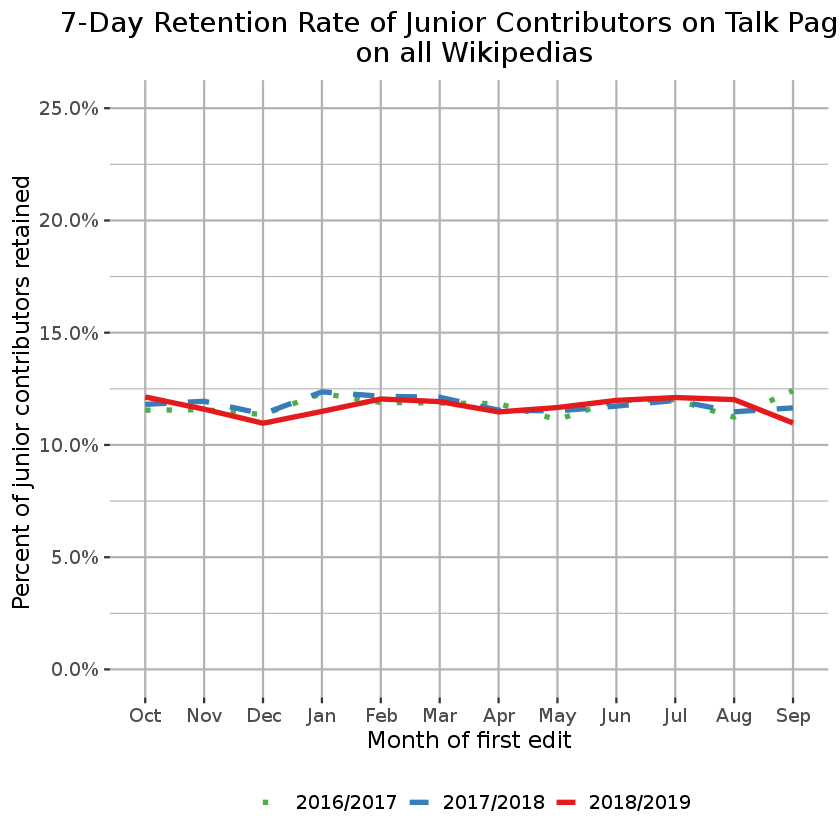

In [47]:
# Plot YoY Changes for Junior Contributors


junior_contributor_first_week_retention_yoy_plot <- talk_contributor_first_week_retention %>%
 filter(initial_edit_count == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


junior_contributor_first_week_retention_yoy_plot$MonthN = factor(junior_contributor_first_week_retention_yoy_plot$MonthN, levels=c("10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09" ))
junior_contributor_first_week_retention_yoy_plot$year = factor(junior_contributor_first_week_retention_yoy_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(junior_contributor_first_week_retention_yoy_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent, limits = c(0, 0.25)) +
  scale_x_discrete(breaks = junior_contributor_first_week_retention_yoy_plot$MonthN, labels = junior_contributor_first_week_retention_yoy_plot$CalMonth)+
  labs(title = "7-Day Retention Rate of Junior Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_first_week_retention_yoy.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [48]:
# Calculate junior year over year retention

talk_contributor_retention_first_week_yoy <- talk_contributor_first_week_retention %>%
   filter(initial_edit_count == 'under 100') %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_retention_first_week_yoy , 10)

month,initial_edit_count,retention_rate,yoy_percent
<date>,<chr>,<dbl>,<dbl>
2019-09-01,under 100,0.1097791,-5.7796541
2019-08-01,under 100,0.1201973,4.7433311
2019-07-01,under 100,0.1211111,1.0617820
2019-06-01,under 100,0.1198500,2.1744196
2019-05-01,under 100,0.1166696,1.3199383
2019-04-01,under 100,0.1147044,-0.6879154
2019-03-01,under 100,0.1192989,-1.6063734
2019-02-01,under 100,0.1204615,-1.0064136
2019-01-01,under 100,0.1149476,-7.0344499


In [49]:
avg <-  talk_contributor_retention_first_week_yoy %>%
    summarise(avg = mean(retention_rate))

avg

avg
<dbl>
0.1175676


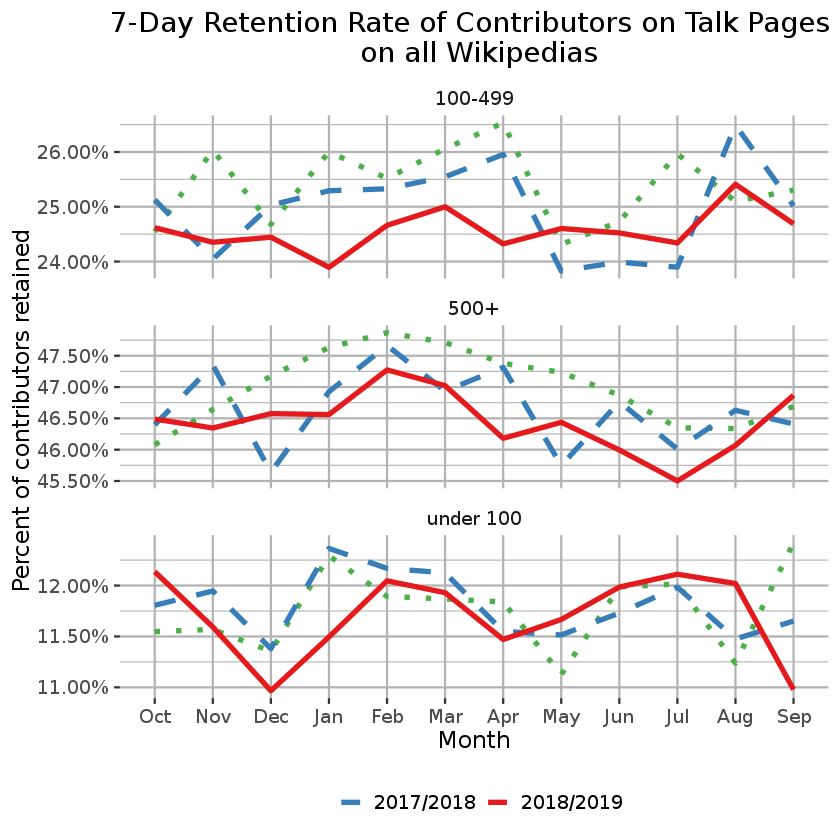

In [64]:
## First week retention rate by user experience

talk_contributor_first_week__retention_yoy_byexperience <- talk_contributor_first_week_retention %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_first_week__retention_yoy_byexperience $MonthN = factor(talk_contributor_first_week__retention_yoy_byexperience $MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

talk_contributor_first_week__retention_yoy_byexperience $year = factor(talk_contributor_first_week__retention_yoy_byexperience $year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_first_week__retention_yoy_byexperience , aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~initial_edit_count, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_first_week__retention_yoy_byexperience$MonthN, labels = talk_contributor_first_week__retention_yoy_byexperience$CalMonth)+
  labs(title = "7-Day Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016,2017','2017/2018', '2018/2019'), values=c(3, 2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))
p
ggsave(filename="talk_contributor_first_week__retention_yoy_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

## Review 8-30 Days Longer-Term Retention Rates

In [ ]:
query<-
"WITH first_edits AS (
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN min(event_user_revision_count) is NULL THEN 'undefined'
            WHEN min(event_user_revision_count) < 100 THEN 'under 100'
            WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count) < 500) THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH')
)
 
SELECT
    month,
    initial_edit_count,
    (count(8_to_30.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is during the second month
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (8*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (30*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS 8_to_30
ON 
(first_edits.user_name = 8_to_30.user_name and
first_edits.first_edit_time = 8_to_30.first_edit_time
)
GROUP BY first_edits.month, first_edits.initial_edit_count" 

results <- collect(sql(query))
save(results, file="Data/talk_contributor_8_to_30_retention.RData")

In [34]:
load("data/talk_contributor_8_to_30_retention.RData")
talk_contributor_8_30_day_retention <- results

In [35]:
talk_contributor_8_30_day_retention$month <- as.Date(talk_contributor_8_30_day_retention$month, format = "%Y-%m-%d")

In [36]:
talk_contributor_8_30_day_retention<- talk_contributor_8_30_day_retention%>%
  filter(month < "2019-10-01") # Remove last month due to censoring 

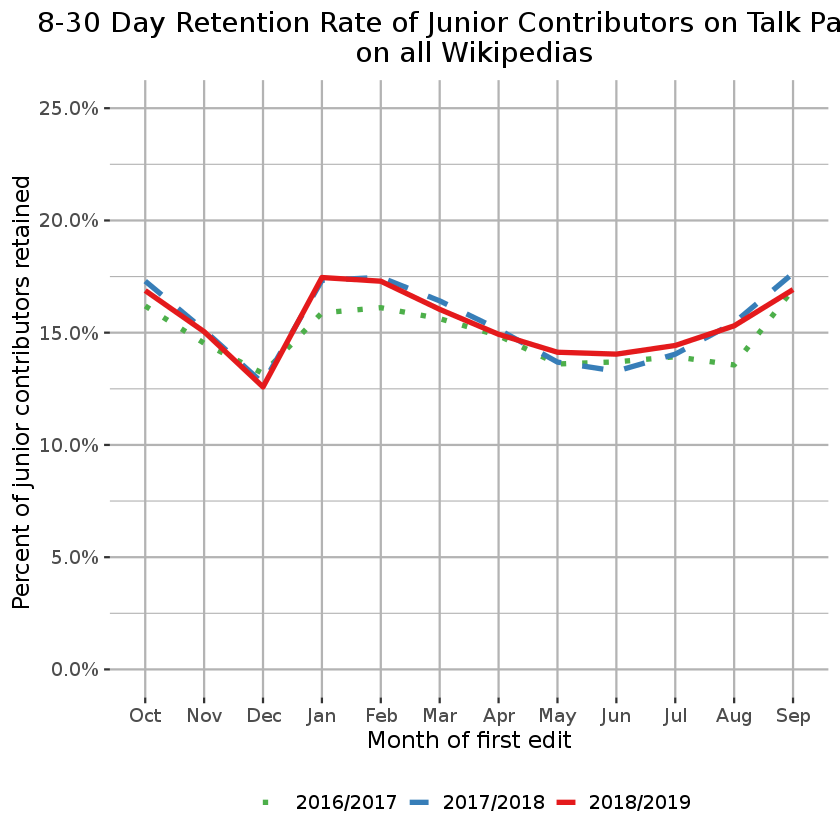

In [37]:
# Plot YoY Changes for Junior Contributors

talk_contributor_8_30_day_retention_yoy_plot <- talk_contributor_8_30_day_retention %>%
 filter(initial_edit_count == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_8_30_day_retention_yoy_plot$MonthN = factor(talk_contributor_8_30_day_retention_yoy_plot$MonthN, levels=c("10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09" ))
talk_contributor_8_30_day_retention_yoy_plot$year = factor(talk_contributor_8_30_day_retention_yoy_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_8_30_day_retention_yoy_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent, limits = c(0, 0.25)) +
  scale_x_discrete(breaks = talk_contributor_8_30_day_retention_yoy_plot$MonthN, labels = talk_contributor_8_30_day_retention_yoy_plot$CalMonth)+
  labs(title = "8-30 Day Retention Rate of Junior Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_8_30_day_retention_yoy.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [38]:
# Calculate junior year over year retention

talk_contributor_retention_8_30_day_yoy <- talk_contributor_8_30_day_retention %>%
   filter(initial_edit_count == 'under 100') %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_retention_8_30_day_yoy, 10)

month,initial_edit_count,retention_rate,yoy_percent
<date>,<chr>,<dbl>,<dbl>
2019-09-01,under 100,0.1692084,-4.1100321
2019-08-01,under 100,0.1530599,-0.9063006
2019-07-01,under 100,0.1443137,2.7607100
2019-06-01,under 100,0.1404500,5.7173648
2019-05-01,under 100,0.1412891,3.2081381
2019-04-01,under 100,0.1492794,-1.4355906
2019-03-01,under 100,0.1603845,-2.3078056
2019-02-01,under 100,0.1729367,-0.9918278
2019-01-01,under 100,0.1745771,0.7222550


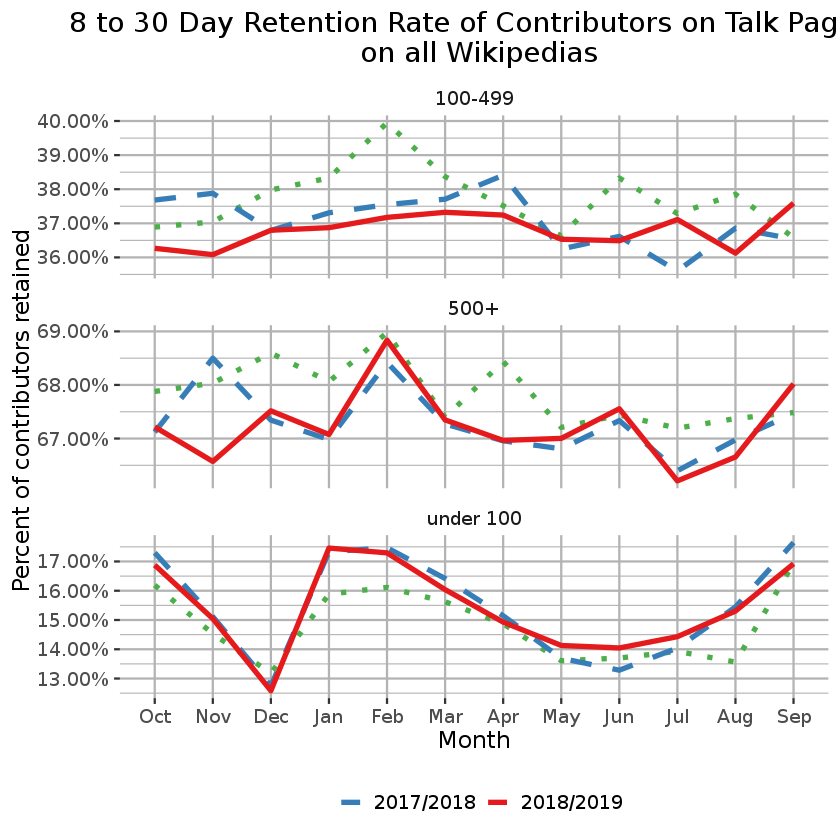

In [39]:
## 8-30 Day retention rate by user experience

talk_contributor_8_30_day_retention_yoy_byexperience_plot <- talk_contributor_8_30_day_retention %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_8_30_day_retention_yoy_byexperience_plot$MonthN = factor(talk_contributor_8_30_day_retention_yoy_byexperience_plot$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

talk_contributor_8_30_day_retention_yoy_byexperience_plot$year = factor(talk_contributor_8_30_day_retention_yoy_byexperience_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_8_30_day_retention_yoy_byexperience_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~initial_edit_count, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_8_30_day_retention_yoy_byexperience_plot$MonthN, labels = talk_contributor_8_30_day_retention_yoy_byexperience_plot$CalMonth)+
  labs(title = "8 to 30 Day Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016,2017','2017/2018', '2018/2019'), values=c(3, 2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="8-30_day_contributor_yoy_retention_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

## Last two week month retention (Days 15 - 30)

In [1]:
query<-
"WITH first_edits AS (
    SELECT
        event_user_text as user_name,
        trunc(event_timestamp, 'MONTH') as month,
        CASE
            WHEN min(event_user_revision_count) is NULL THEN 'undefined'
            WHEN min(event_user_revision_count) < 100 THEN 'under 100'
            WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count) < 500) THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
        min(event_timestamp) as first_edit_time
    FROM wmf.mediawiki_history mh
    INNER JOIN canonical_data.wikis
    ON
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_timestamp >= '2016-10-01' and
        event_timestamp < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        not event_user_is_anonymous and
        event_entity = 'revision' and
        event_type = 'create' and
        mh.snapshot = '2019-10'
    GROUP BY event_user_text,  trunc(event_timestamp, 'MONTH')
)
 
SELECT
    month,
    initial_edit_count,
    (count(15_to_30.user_name) / count(*)) as retention_rate
FROM first_edits
LEFT JOIN
(
    SELECT event_user_text as user_name,
    first_edits.first_edit_time,
    min(event_timestamp) as return_time
    FROM wmf.mediawiki_history mh
    INNER JOIN first_edits
    ON mh.event_user_text = first_edits.user_name
    INNER JOIN canonical_data.wikis
    ON 
        wiki_db = database_code and
        database_group ==  'wikipedia'
    WHERE
        event_entity = 'revision' and
        event_type = 'create' and
        not event_user_is_anonymous and
        snapshot = '2019-10' and
        first_edits.first_edit_time >= '2016-10-01' and
        first_edits.first_edit_time  < '2019-11-01' and
        page_namespace_historical % 2 == 1 and
        -- second revision is during the second month
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') >=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (15*24*60*60)) and
        unix_timestamp(event_timestamp, 'yyyy-MM-dd HH:mm:ss.0') <=
            (unix_timestamp(first_edits.first_edit_time, 'yyyy-MM-dd HH:mm:ss.0') + (30*24*60*60))
    GROUP BY event_user_text, first_edits.first_edit_time
) AS 15_to_30
ON 
(first_edits.user_name = 15_to_30.user_name and
first_edits.first_edit_time = 15_to_30.first_edit_time
)
GROUP BY first_edits.month, first_edits.initial_edit_count" 

results <- collect(sql(query))
save(results, file="data/talk_contributor_15_to_30_retention.RData")

ERROR: Error in eval(expr, envir, enclos): could not find function "collect"


In [4]:
load("data/talk_contributor_15_to_30_retention.RData")
talk_contributor_15_to_30_retention <- results

In [5]:
head(talk_contributor_15_to_30_retention)

month,initial_edit_count,retention_rate
<date>,<chr>,<dbl>
2017-07-01,under 100,0.1019326
2018-05-01,500+,0.5935041
2019-08-01,100-499,0.2801724
2018-04-01,100-499,0.3072745
2018-09-01,100-499,0.2862296
2018-08-01,100-499,0.2921168


In [6]:
talk_contributor_15_to_30_retention$month <- as.Date(talk_contributor_15_to_30_retention$month, format = "%Y-%m-%d")

In [9]:
talk_contributor_15_to_30_retention<- talk_contributor_15_to_30_retention%>%
  filter(month < "2019-10-01") # Remove last month due to censoring 

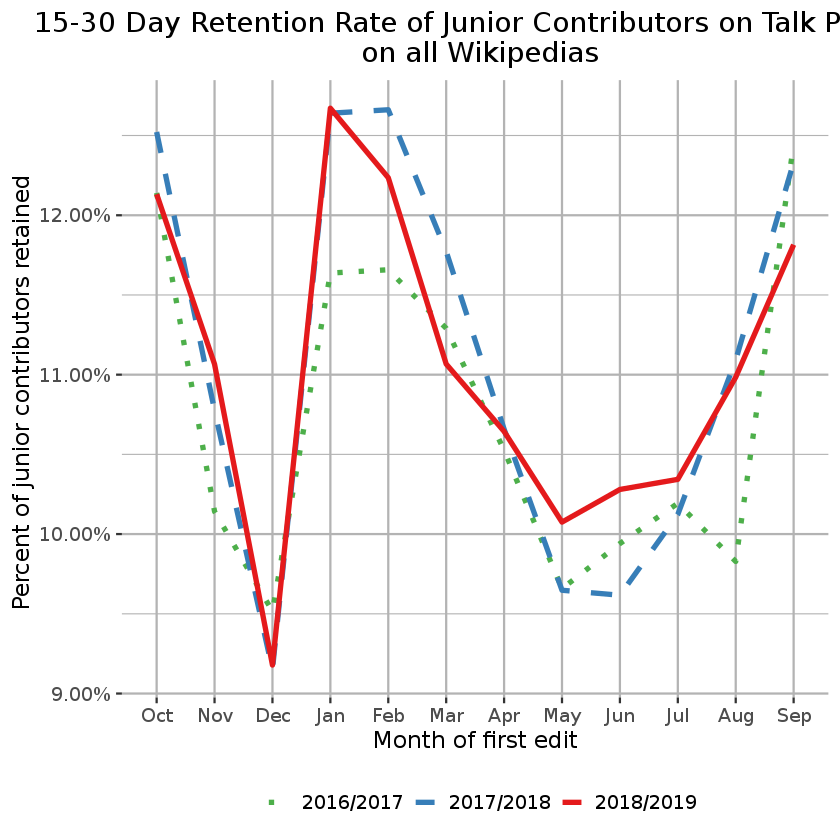

In [40]:
# Plot YoY Changes for Junior Contributors

talk_contributor_15_to_30_retention_yoy_plot <- talk_contributor_15_to_30_retention %>%
 filter(initial_edit_count == 'under 100') %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_15_to_30_retention_yoy_plot$MonthN = factor(talk_contributor_15_to_30_retention_yoy_plot$MonthN, levels=c("10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09" ))
talk_contributor_15_to_30_retention_yoy_plot$year = factor(talk_contributor_15_to_30_retention_yoy_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_15_to_30_retention_yoy_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5
           ) +
  scale_y_continuous("Percent of junior contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_15_to_30_retention_yoy_plot$MonthN, labels = talk_contributor_15_to_30_retention_yoy_plot$CalMonth)+
  labs(title = "15-30 Day Retention Rate of Junior Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month of first edit") +
        scale_color_brewer(palette = 'Set1', breaks=c('2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016/2017','2017/2018', '2018/2019'), values=c(3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="talk_contributor_15_to_30_retention_yoy.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  

In [15]:
# Calculate junior year over year retention

talk_contributor_15_to_30_retention_yoy <- talk_contributor_15_to_30_retention %>%
   filter(initial_edit_count == 'under 100') %>%
   arrange(month) %>%
   mutate(yoy_percent = (retention_rate/lag(retention_rate,12) -1) *100) %>%
   arrange(desc(month))

head(talk_contributor_15_to_30_retention_yoy, 10)

month,initial_edit_count,retention_rate,yoy_percent
<date>,<chr>,<dbl>,<dbl>
2019-09-01,under 100,0.11815109,-4.1906340
2019-08-01,under 100,0.10984084,-0.9730470
2019-07-01,under 100,0.10343513,2.1743200
2019-06-01,under 100,0.10280000,6.8988594
2019-05-01,under 100,0.10075214,4.4302519
2019-04-01,under 100,0.10643989,-0.1365450
2019-03-01,under 100,0.11066717,-5.9980438
2019-02-01,under 100,0.12235212,-3.3673276
2019-01-01,under 100,0.12671270,0.2478918


In [41]:
avg <-  talk_contributor_15_to_30_retention_yoy %>%
    summarise(avg = mean(retention_rate))

avg

avg
<dbl>
0.1095729


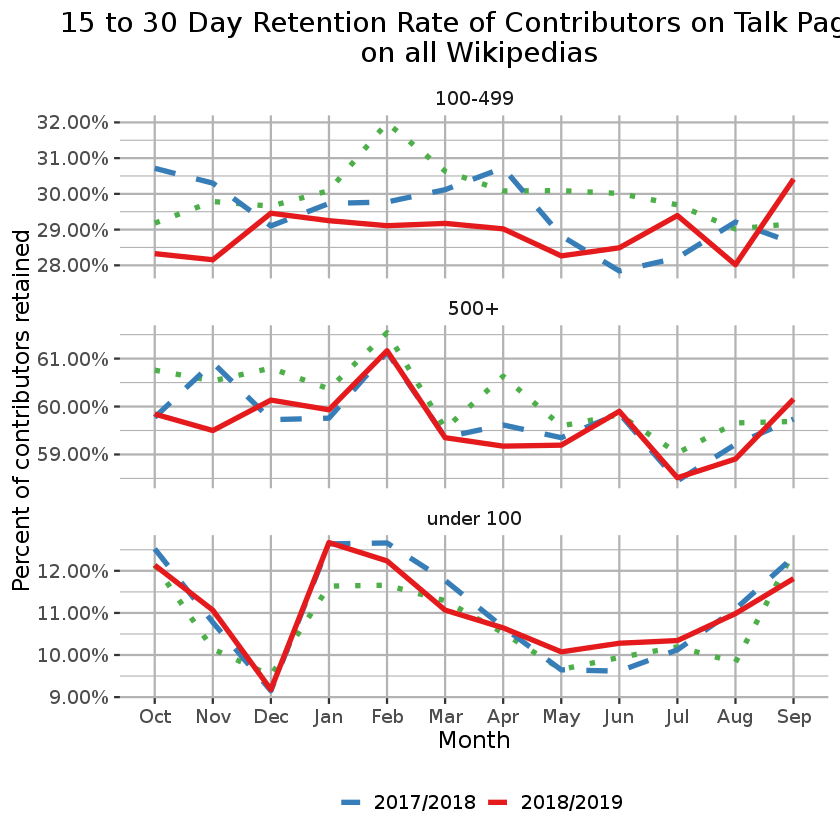

In [19]:
## 15-30 Day retention rate by user experience

talk_contributor_15_to_30_retention_yoy_byexperience_plot <- talk_contributor_15_to_30_retention %>%
 mutate(year = case_when(month >= '2016-10-01' & month < '2017-10-01' ~ '2016/2017',
                         month >= '2017-10-01' & month < '2018-10-01' ~ '2017/2018',
                         month >= '2018-10-01' & month < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(month),"%m")),
         CalMonth = months(as.Date(month), abbreviate=TRUE))


talk_contributor_15_to_30_retention_yoy_byexperience_plot$MonthN = factor(talk_contributor_15_to_30_retention_yoy_byexperience_plot$MonthN, levels=c( "10", "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09"))

talk_contributor_15_to_30_retention_yoy_byexperience_plot$year = factor(talk_contributor_15_to_30_retention_yoy_byexperience_plot$year, levels = c('2016/2017','2017/2018','2018/2019'))


p <- ggplot(talk_contributor_15_to_30_retention_yoy_byexperience_plot, aes(x=MonthN, y = retention_rate, group = year, color = year, linetype = year)) +    
  geom_line(size = 1.5) +
  facet_wrap(~initial_edit_count, nrow = 3, scale = "free_y") +
  scale_y_continuous("Percent of contributors retained ", labels = scales::percent) +
  scale_x_discrete(breaks = talk_contributor_15_to_30_retention_yoy_byexperience_plot$MonthN, labels = talk_contributor_15_to_30_retention_yoy_byexperience_plot$CalMonth)+
  labs(title = "15 to 30 Day Retention Rate of Contributors on Talk Pages \n on all Wikipedias") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2016,2017','2017/2018', '2018/2019'), values=c(3, 2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))

p
ggsave(filename="15-30_day_contributor_yoy_retention_byexperience.png", plot = p, path = 'Figures',  width = 12, height = 8, units = "in", dpi = 150)  